In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import librosa
from tqdm import tqdm
from scipy.stats import skew
import seaborn as sns

# Music waveform analysis and trascription

## Project Overview

The purpose of this project is to analyse the soundwaves of different music types, focusing on classical music, use deep learning to extract important features and transform the music into notes, use machine learning to cluster different genres. In order to have more structure in the project I am going to start analyzing one of the datasets and trying to perform some analysis and operations on that. After that I am going to do the same on the other one with modern music. After each analysis I will run the waves through a model to try and predict outcomes.


# Classical music waveforms EDA

To begin with, I am going to use a dataset that contains classical music. It is probably the easiest to transcribe into notes. We are going to begin by getting some data. The source I am using is from Mini MusicNet since the big MusicNet contains a huge amount of data that would require a lot of computational power and time.

Let us explain how our data looks like. We have a lot of data points, 82,500 samples to be exact. Each of them has 4096 features. We expect those 4096 features to be the **raw amplitudes.** To make it simpler:

- **Number of samples:** 82,500  
- **Input features per sample:** 4,096 (representing audio features)  
- **Output labels per sample:** 128 (binary indicators for each note)  
- **Duration per sample:** 256 milliseconds  
- **Sampling rate:** 16,000 Hz  


In [3]:

Xtrain = np.load('audio-train.npy')
Ytrain = np.load('labels-train.npy')
Xvalid = np.load('audio-valid.npy')
Yvalid = np.load('labels-valid.npy')
Xtest = np.load('audio-test.npy')
Ytest = np.load('labels-test.npy')

Now that we have loaded the data we can give an example of how the raw data looks like. **The data we are using are 9ms recording.**

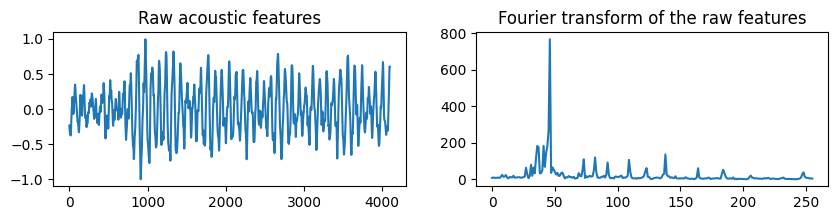

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10,2))
ax[0].set_title('Raw acoustic features')
ax[0].plot(Xtrain[2])
ax[1].set_title('Fourier transform of the raw features')
ax[1].plot(np.abs(np.fft.rfft(Xtrain[2])[0:256])) # clip to 256 for the interval of 0Hz to 1kHz

What we just did was to take one of the files we have, show it's raw version and then the fourier transform. 
- **Left plot (Raw acoustic features):**  
  This shows the raw audio waveform values over time for one sample from `Xtrain[0]`. The x-axis represents the time steps or audio samples (ranging approximately from 0 to 4100), and the y-axis shows the amplitude of the audio signal at each time step (ranging from about -1 to 1). The waveform represents how the air pressure (sound wave) changes over time in the audio clip.

- **Right plot (Fourier Transform of the raw features):**  
  This shows the magnitude of the frequency components obtained by applying the Fast Fourier Transform (FFT) to the raw audio waveform.  
  The x-axis represents frequency bins (up to 256 in this clipped visualization), and the y-axis represents the amplitude (strength) of each frequency component. The FFT decomposes the time-domain signal into its frequency components, revealing which frequencies are present in the audio and their intensities.

**Summary:**  
- The raw waveform (left) shows how the sound varies over time.  
- The Fourier transform (right) shows the distribution of frequencies that make up the sound.  
These two views provide complementary insights into the audio: time domain vs frequency domain.


This means for each bin:
$$
f = \frac{\text{bin\_index} \times f_s}{N}
$$

where:  
- $ f $ is the frequency corresponding to the FFT bin,  
- $ \text{bin\_index} $ is the index of the FFT bin (0, 1, 2, $\ldots$),  
- $ f_s $ is the sampling rate (in Hz),  
- $ N $ is the FFT size (number of samples).

**Example:**  
If the sampling rate $ f_s = 16,000 $ Hz, FFT size $ N = 4,096 $, and the bin index is 50, then the frequency is:

$$
f = \frac{50 \times 16,000}{4,096} \approx 195.31 \text{ Hz}
$$


For a reference let us see which note that would be on the guitar. We see that the open G string is relatively close to the frequency we had. This means that the frequency that was available in this small sample was the G note.
<img src="https://musicmaster.in/music-tools/tuner/string-freq.png" alt="Guitar Tuning Frequencies" width="400"/>

Now that we are familiar with what the waveforms look like we are going to go thorugh some simple analysis of the data so we have an idea of what we are working with.

In [14]:
print("Xtrain shape:", Xtrain.shape)
print("Ytrain shape:", Ytrain.shape)
print("Xtest shape:", Xtest.shape)
print("Ytest shape:", Ytest.shape)

Xtrain shape: (62500, 4096)
Ytrain shape: (62500, 128)
Xtest shape: (10000, 4096)
Ytest shape: (10000, 128)


In [15]:
print("Number of active notes per sample (mean):", np.mean(np.sum(Ytrain, axis=1)))
print("Label sparsity:", np.mean(Ytrain))  # Proportion of 1s in labels

Number of active notes per sample (mean): 2.941808
Label sparsity: 0.022982875


What we just did was calculate the average number of active notes per sample. We achieved this by summing the columns of `Ytrain`, which is multi-one-hot encoded: each entry is `1` if a note is active in a given sample and `0` otherwise.

Before we keep on with the preprocessing of the data I am going to run some analysis on the frequencies we got.

In [6]:
print("Xtrain dtype:", Xtrain.dtype)
print("Ytrain dtype:", Ytrain.dtype)

Xtrain dtype: float32
Ytrain dtype: float32


We see that the Xtrain and the Ytrain are of different types. We are going to change that so that we can pass them more safely to our model later on.

In [7]:
Ytrain = Ytrain.astype(np.float32)

In [8]:
print("Sample Xtrain[0]:", Xtrain[0])
print("Sample Ytrain[0]:", Ytrain[0])

Sample Xtrain[0]: [-0.01537969 -0.0221083  -0.03524511 ...  0.16404998  0.17494392
  0.19032362]
Sample Ytrain[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


We can also see the relationship between played and unplayed notes.

Unique labels and counts: {0.0: 7816137, 1.0: 183863}


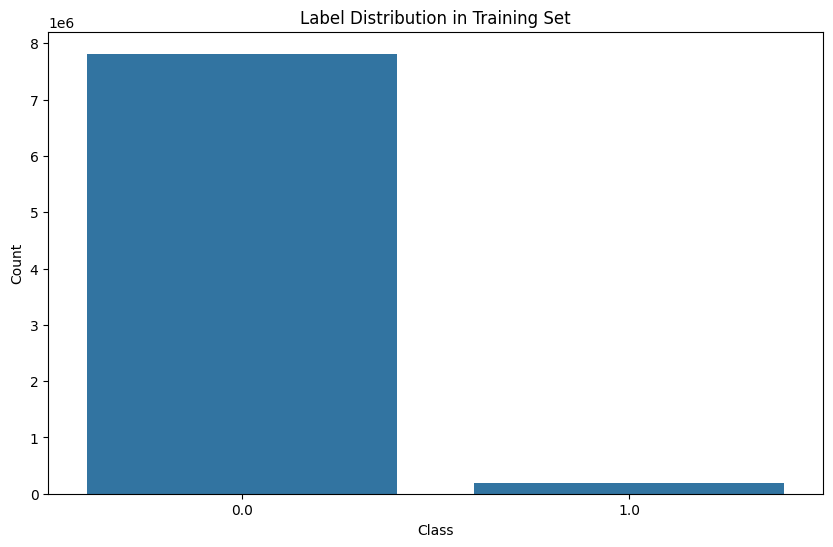

In [9]:


unique, counts = np.unique(Ytrain, return_counts=True)
print("Unique labels and counts:", dict(zip(unique, counts)))

# Visualize label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=Ytrain.ravel())
plt.title("Label Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#### Checking normality of data
I am going to see the mean, std, min and max of the `Xtrain` dataset in order to know if any normalization might be necessary before working with model.

In [10]:
print("Xtrain stats - Mean:", np.mean(Xtrain), "Std:", np.std(Xtrain), 
      "Min:", np.min(Xtrain), "Max:", np.max(Xtrain))

Xtrain stats - Mean: -8.922857e-06 Std: 0.34472543 Min: -1.0 Max: 1.0


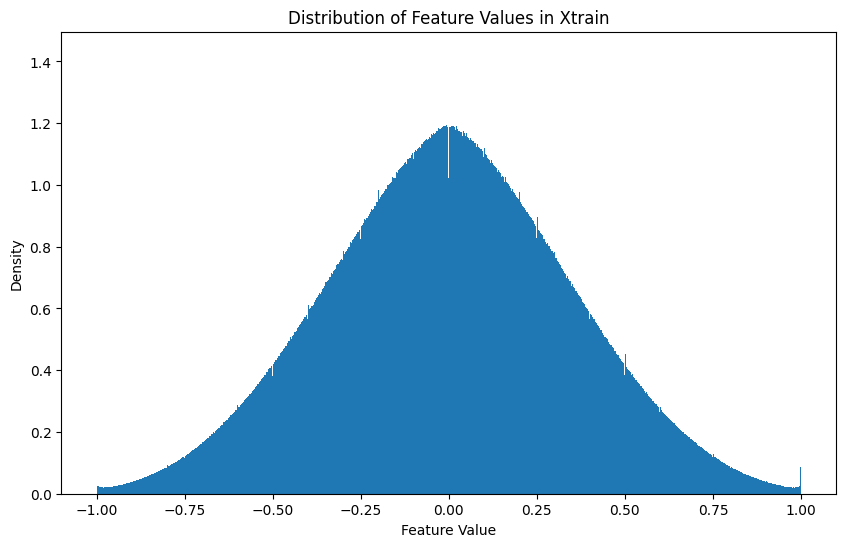

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(Xtrain.flatten(), bins=1000, density=True)
plt.title("Distribution of Feature Values in Xtrain")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.show()

What we just took a look at is the distribution of the features values in the Xtrain. We can easily see that they are equally distributed with a mean close to 0 and a standartd deviation of 0.34 which is something very standard. This is absolutely expected normalized audio data.

## Mean amplitude, variance, skewness
To gain some more information about the waveform characteristics in our dataset, I will analyze three fundamental statistical properties: **mean amplitude, variance, and skewness** for both the training and validation sets. These metrics provide insights into the overall structure and distribution of the audio signals. The mean amplitude indicates the average energy level of the waveforms, variance reflects the dynamic range or intensity fluctuations, and skewness reveals the asymmetry in the signal distribution. 

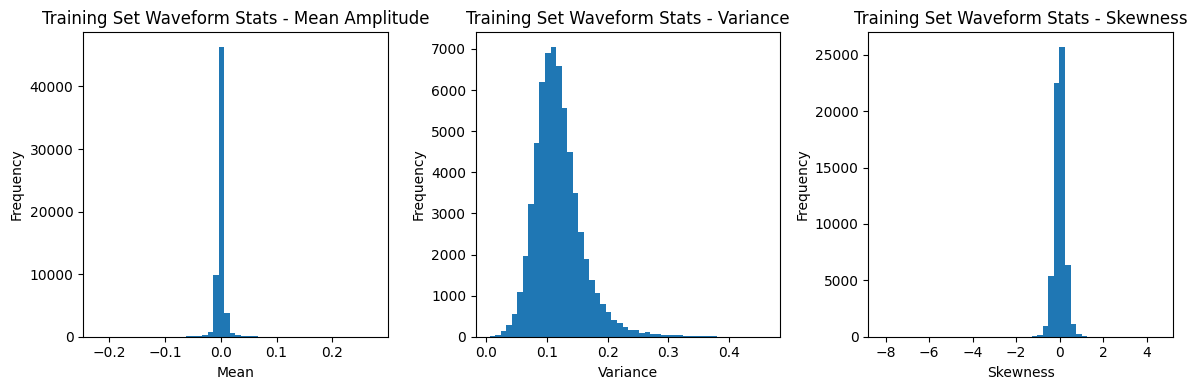

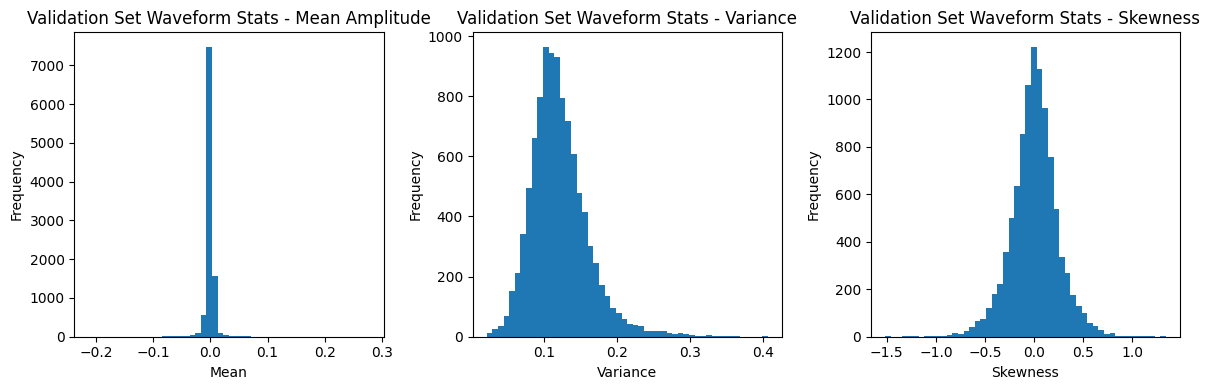

In [21]:
def plot_waveform_stats(X, title):
    means = np.mean(X, axis=1)
    variances = np.var(X, axis=1)
    skewness = skew(X, axis=1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(means, bins=50)
    plt.title(f"{title} - Mean Amplitude")
    plt.xlabel("Mean")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 3, 2)
    plt.hist(variances, bins=50)
    plt.title(f"{title} - Variance")
    plt.xlabel("Variance")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 3, 3)
    plt.hist(skewness, bins=50)
    plt.title(f"{title} - Skewness")
    plt.xlabel("Skewness")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_waveform_stats(Xtrain, "Training Set Waveform Stats")
plot_waveform_stats(Xvalid, "Validation Set Waveform Stats")

### Moments
1. In the first plot the narrow distribution around 0 indicates that the audio samples are likely preprocessed, which is standard for machine learning tasks. However, the extreme concentration suggests limited variability in amplitude. Pretty much the same is seen with the validation set, with a lower freqency of course, since it contains less samples.
2. The variance distribution has a broad peak between 0.1 and 0.2, with a high frequency in this range, dying off as variance increases beyond 0.3. This shows that most samples have moderate variability in amplitude, which is typical for audio with dynamic changes.
3. The last plot showing skewness measures the asymmetry of the amplitude distribution. A value near 0 indicates a symmetric distribution, which is expected if the audio is well-balanced. The positive tail suggests some samples have right-skewed distributions, possibly due to brief loud events or clipping, but the dominance of 0 skewness aligns with normalized data.

## Absolute mean
In the last task we saw that the mean of the amplitute is around zero suggesting well-distributed data. Now however we will look at one more thing, which is the absolute mean.

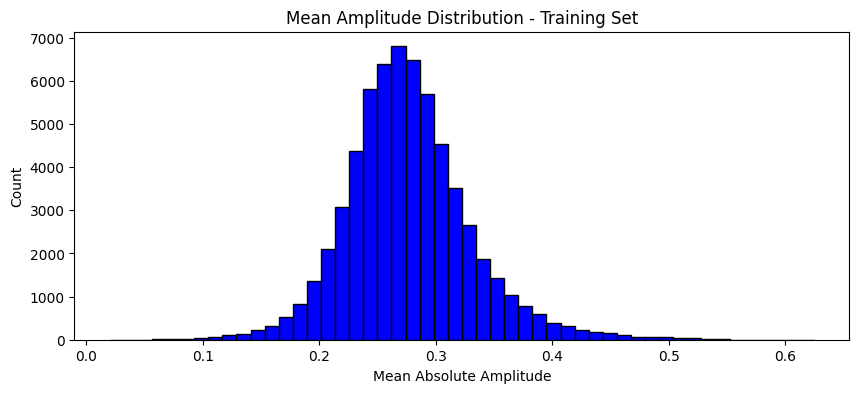

Mean of mean amplitudes: 0.27614978
Mean of std amplitudes: 0.3401256
Mean of peak-to-peak: 1.8715175


In [23]:

mean_amplitudes = np.mean(np.abs(Xtrain), axis=1)
std_amplitudes = np.std(Xtrain, axis=1)
peak_to_peak = np.ptp(Xtrain, axis=1)


plt.figure(figsize=(10, 4))
plt.hist(mean_amplitudes, bins=50, color='blue', edgecolor='black')
plt.title('Mean Amplitude Distribution - Training Set')
plt.xlabel('Mean Absolute Amplitude')
plt.ylabel('Count')
plt.savefig('amplitude_dist_training.png')
plt.show()

# Print basic statistics
print("Mean of mean amplitudes:", np.mean(mean_amplitudes))
print("Mean of std amplitudes:", np.mean(std_amplitudes))
print("Mean of peak-to-peak:", np.mean(peak_to_peak))


Again, from this analysis, we can say that our data is acting as expected, showing consistent amplitude ranges, variability, and dynamic range across samples - indicating good signal quality and no major anomalies that would require immediate preprocessing adjustments.

## Analyzing energy

### What is RMS?

For the next part we re going to look at something a little bit more complex. **The RMS measure of the average power or intensity of an audio signal over time.** It is calculated with the formula: $$ \text{RMS} = \sqrt{\frac{1}{N}\sum_{i=1}^N x_i^2}$$
where:
- $x(t)$ is a waveform
- $N$ is the number of samples

Before we go further, I am going to explain frame length and hop length which are necessary parameters that we are going to deal with. When we want to calculate the RMS it is not only necessary to have the waveforms and the number of samples. We need to decide how we are going to group different frames.

### Frame length and hop length

**Frame Length:** The number of samples in each analysis window (frame) for computing RMS energy. It determines the time duration of each RMS measurement.

Formula: $$\text{Duration of frame} =  \frac{\text{frame\_length}}{\text{sampling\_rate}} $$

For `frame_length=256` at 16,000 Hz: $ \frac{256}{16000} = 0.016 \, \text{seconds} = 16 \, \text{ms} $.
Larger frame lengths smooth the RMS energy, capturing broader trends but potentially missing rapid changes (e.g., note onsets). Smaller frames provide finer temporal resolution but may be noisy.


**Hop Length:** The number of samples between the start of consecutive frames. It controls the overlap between frames and the temporal resolution of the output.

Formula: $$\text{Hop duration} =  \frac{\text{hop\_length}}{\text{sampling\_rate}} $$

For `hop_length=64` at 16,000 Hz: $ \frac{64}{16000} = 0.004 \, \text{seconds} = 4 \, \text{ms} $.
Smaller hop lengths increase overlap (more frames, higher resolution) but increase computation. Larger hop lengths reduce overlap, potentially missing short events.


**Output:** For a 4,096-sample waveform, `librosa.feature.rms` produces a time series of RMS values. Number of frames:
$$\text{Number of frames} = \left\lfloor \frac{\text{signal\_length} - \text{frame\_length}}{\text{hop\_length}} \right\rfloor + 1$$
With frame_length=256, hop_length=64, and signal length 4,096:
$$\text{Number of frames} = \left\lfloor \frac{4096 - 256}{64} \right\rfloor + 1 = \left\lfloor \frac{3840}{64} \right\rfloor + 1 = 60 + 1 = 61 \, \text{frames}$$
Each frame represents 16 ms, with a new frame every 4 ms

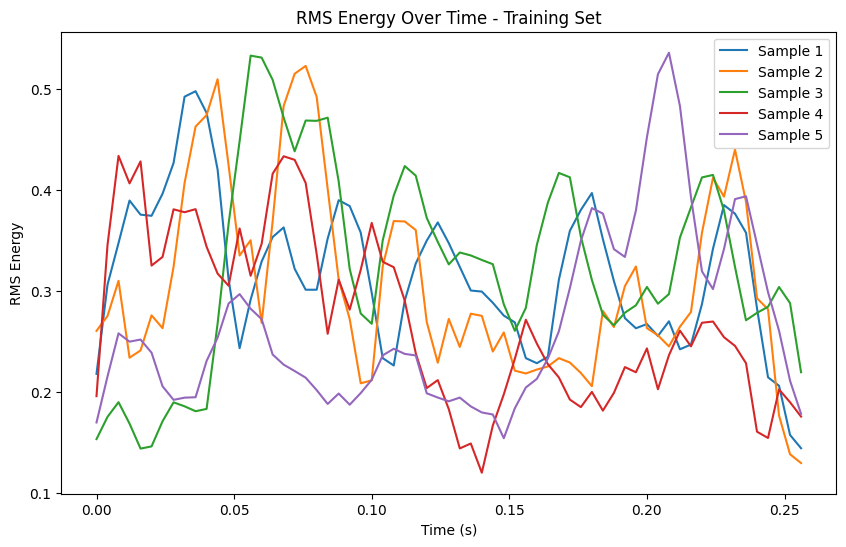

In [41]:
r = 16000
frame_length = 256  # 16 ms
hop_length = 64    # 4 ms

# Compute frame-based RMS for first 5 samples
all_rms = []
plt.figure(figsize=(10, 6))
for i in range(5):
    rms = librosa.feature.rms(y=Xtrain[i], frame_length=frame_length, hop_length=hop_length)[0]
    all_rms.append(rms)
    times = np.arange(len(rms)) * hop_length / sr
    plt.plot(times, rms, label=f'Sample {i+1}')

plt.title('RMS Energy Over Time - Training Set')
plt.xlabel('Time (s)')
plt.ylabel('RMS Energy')
plt.legend()
plt.show()
plt.close()


In our context we need to see what that means.
- High RMS values indicate loud sections (forte piano).
- Low RMS values suggest soft passages or silences.
- Sudden RMS increases often align with note onsets, which could actually be useful for transcription.

## Lower frequency tendency in classical music
![Frequency of instruments](https://slideplayer.com/slide/16845789/97/images/13/Frequency+of+Instruments.jpg)

It is expected for classical music to exhibit a lower overall frequency profile compared to modern genres like rock, metal, or pop. This trend is primarily due to the nature and frequency ranges of the instruments typically used in classical compositions.
Instrument Frequency Ranges

- **Double** Bass: 41 Hz – 294 Hz (E1 – D3)
- **Cello**: 65 Hz – 659 Hz (C2 – E4)
- **Viola**: 131 Hz – 1,319 Hz (C3 – G5)
- **Violin**: 196 Hz – 3,136 Hz (G3 – G7)
- **Bassoon**: 58 Hz – 587 Hz (B♭0 – D4)
- **Contrabassoon**: 29 Hz – 233 Hz (B♭0 – B♭2)
- **Tuba**: 49 Hz – 587 Hz (B♭0 – D4)
- **Trombone**: 82 Hz – 698 Hz (E2 – F4)
- **French** Horn: 78 Hz – 932 Hz (B♭1 – A4)
- **Trumpet**: 164 Hz – 1,048 Hz (E3 – C5)
- **Flute**: 262 Hz – 2,093 Hz (C4 – C7)
- **Piccolo**: 523 Hz – 4,186 Hz (C5 – C8)
- **Oboe**: 233 Hz – 1,568 Hz (B♭3 – G6)
- **Clarinet**: 164 Hz – 1,397 Hz (E3 – F6)
- **Piano**: 27 Hz – 4,186 Hz (A0 – C8)
- **Harp**: 32 Hz – 3,136 Hz (C1 – G7)

As we can observe, many of these classical instruments occupy the lower to mid-frequency spectrum. Instruments like the double bass, contrabassoon, tuba, and cello are fundamentally low-pitched and form the bass foundation of orchestral music. Even higher-pitched instruments, such as the violin or flute, often play within moderate frequency ranges, and their upper limits are rarely sustained except for expressive or soloistic purposes.

Furthermore, when we encounter higher frequencies in these instruments, they are often not from the fundamental pitches but from overtones or harmonics. These overtones are naturally occurring vibrations at integer multiples of the fundamental frequency and are responsible for the richness and color of the sound, rather than significantly altering the musical pitch range itself.

To better visualize this trend, I will now show a plot comparing the frequency ranges of various classical instruments, highlighting the overall tendency toward the lower end of the audible spectrum.

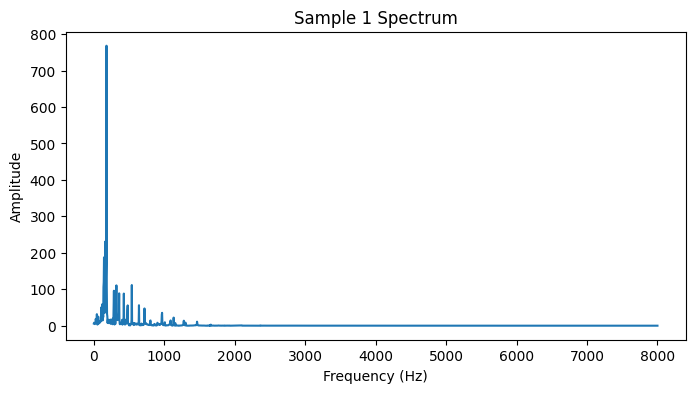

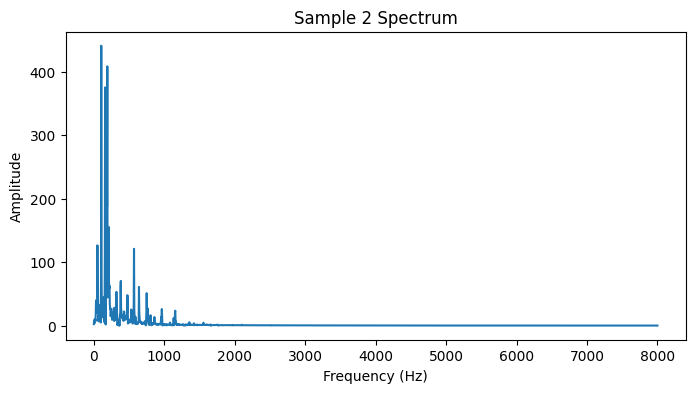

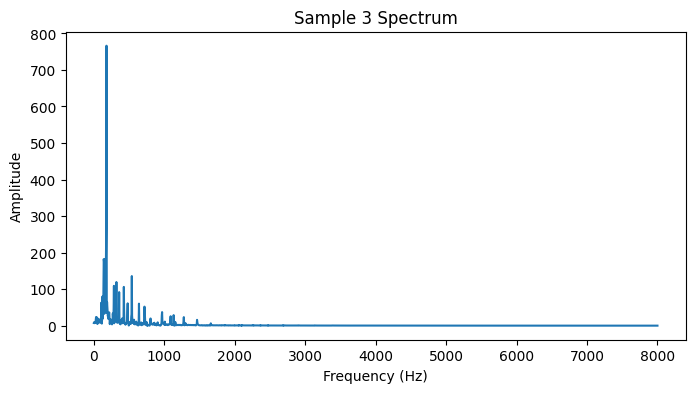

In [47]:
def plot_spectrum(waveform, sr=16000, title="Spectrum"):
    fft = np.abs(np.fft.rfft(waveform))
    freqs = np.fft.rfftfreq(len(waveform), 1/sr)
    plt.figure(figsize=(8, 4))
    plt.plot(freqs, fft)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

# Example for a few samples
for i in range(3):
    plot_spectrum(Xtrain[i], title=f"Sample {i+1} Spectrum")

The frequency spectra for Samples 1, 2, 3 reveal a consistent pattern where the majority of the amplitude is concentrated below 1000 Hz, with a sharp peak near 0 Hz and a rapid decline in energy as frequencies increase toward 8000 Hz. This distribution aligns with our hypothesis that classical music exhibits a dominance of lower frequencies, reflecting the fundamental ranges of orchestral instruments . The minimal energy above 1000 Hz further supports the idea that the dataset captures the characteristic low-frequency richness of classical music.

## Working with spectograms

Firstly, let us explain what a spectrogram is. A spectrogram is a visual representation of the spectrum of frequencies in a signal as they vary over time. It is widely used in audio analysis to understand how the energy of different frequency components changes throughout a recording.

When reading spectrograms, we typically interpret three key components:

**X-axis: Represents time** — showing when events occur in the signal.

**Y-axis: Represents frequency** — showing which frequencies are present.

**Color (or intensity)**: Represents the amplitude or strength of each frequency at a given moment. Brighter areas indicate higher intensity (louder sound), while darker areas indicate lower intensity.

Let us go over an example:

<img src="https://splice.com/blog/wp-content/uploads/2023/04/image1.png" alt="Example" width="500"/>
In this picture, we can see the spectrogram of a bass guitar. Notice how most of the energy is concentrated in the lower frequency range (lower part of the Y-axis), which is typical for bass instruments. The horizontal lines show the sustained notes, and their thickness or brightness indicates their strength. You can also observe subtle variations in intensity over time, reflecting the dynamics and articulation of the playing.

### Spectograms in deep learning models
When we need to create a model that is able to distinguish different notes(i.g., be able to detect frequencies at a specific time) this means that we need to give the model something from which it might extract more meaningful features. Spectograms allow us to do exatcly that especially combined with CNN. In our case we are going to use a specific type of spectograms: **Mel spectograms.** The interesting thing about those type of spectograms is that they use a scale that aims to mimic how people perceive pitch. I am going to transform the raw data that we have to Mel spectograms. **The knowledge we have of hop lengths and frame lengths is also applicable here**

![Spectogram](https://tse3.mm.bing.net/th/id/OIP.ll0gfr1Z05Sjh6rlHuKkZwHaC0?r=0&rs=1&pid=ImgDetMain&o=7&rm=3)

In [48]:
sr = 16000
n_mels = 64  # Number of mel frequency bins
n_fft = 2048  # Length of FFT window
hop_length = 1024  # Number of samples between successive frames

# Optimized function to create mel spectrograms with progress bar
def create_mel_spectrograms(waveforms, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length):
    # Preallocate list for efficiency
    specs = []
    # Add progress bar for loading
    for waveform in tqdm(waveforms, desc="Generating Mel Spectrograms", unit="sample"):
        mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels
        specs.append(mel_spec_db)
    return np.array(specs)


Xtrain_spec = create_mel_spectrograms(Xtrain)
np.save('Xtrain_spec.npy', Xtrain_spec)  # Save 

# Function to plot statistics of mel spectrogram means
def spectrogram_stats(specs, title):
    means = np.mean(specs, axis=(1, 2))
    plt.figure(figsize=(6, 4))
    plt.hist(means, bins=50)
    plt.title(f"{title} - Mean Mel Spectrogram Intensity")
    plt.xlabel("Mean Intensity (dB)")
    plt.ylabel("Frequency")
    plt.show()

# Plot the statistics
spectrogram_stats(Xtrain_spec, "Training Mel Spectrogram Stats")

Generating Mel Spectrograms:   1%|▍                                           | 558/62500 [00:02<03:46, 273.47sample/s]


KeyboardInterrupt: 

## Overview
What we did up to this point was to read the information from the MiniNet data set, do some EDA, we showed that the data is normalized, we looked at some charactaristics of the data such as frequency ranges, mean amplitude, variance, skewness, RSM. We also explained why spectograms might be a useful way of displaying the data and how they contain more information.

# Raw data deep learning model
In this part, after examining the data for classical music that we have I am going try and train a model to transcribe the music.

## Preprocessing the data

To begin with, I am going to normalize the features so that they have a mean of 0 and a standard deviation of 1. This is an important preprocessing step when working with neural networks, as it helps improve convergence during training and ensures that the network treats all input features on a comparable scale. Without normalization, features with larger values could dominate the learning process, potentially leading to suboptimal results.

In [56]:
Xtrain_norm = (Xtrain - np.mean(Xtrain, axis=1, keepdims=True)) / np.std(Xtrain, axis=1, keepdims=True)
Xtest_norm = (Xtest - np.mean(Xtest, axis=1, keepdims=True)) / np.std(Xtest, axis=1, keepdims=True)

The next things we ought to do is to convert all this information into PyTorch tensors so that we can work with them. The library I am going to use is `PyTorch`.

In [57]:

# Convert to PyTorch tensors
Xtrain_tensor = torch.tensor(Xtrain_norm, dtype=torch.float32)
Ytrain_tensor = torch.tensor(Ytrain, dtype=torch.float32)
Xtest_tensor = torch.tensor(Xtest_norm, dtype=torch.float32)
Ytest_tensor = torch.tensor(Ytest, dtype=torch.float32)


We use a DataLoader with TensorDataset to efficiently feed our training data to the model in manageable batches, which helps optimize memory usage and accelerates training by enabling mini-batch gradient descent. Setting shuffle=True ensures that the model sees the data in a different order each epoch, which helps prevent overfitting and improves generalization.


In [58]:
# Create DataLoaders
train_dataset = TensorDataset(Xtrain_tensor, Ytrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

## Building a nerual network

In this next part, I am going to start training a network to predict which notes are being played. One of the key challenges now is deciding how to structure the network and what types of layers to include. **To begin with, we will build a typical feedforward network (Multilayer Perceptron), where we progressively reduce the dimensionality of the data. We'll use ReLU activation functions to introduce non-linearity and Dropout layers to help prevent overfitting.**

This model is a simple **feedforward neural network** designed for **multi-label classification**. It takes in **flattened input vectors of size 4096**, which are assumed to represent features extracted from audio.

## Model Architecture

- **Input layer:** 4096 features — represents the flattened audio input.
- **First hidden layer:** 512 neurons with **ReLU** activation  
  - This layer reduces the high-dimensional input to a more manageable representation while capturing important patterns.
- **Dropout layer:** with a probability of 0.3 applied after the first hidden layer  
  - Helps prevent overfitting by randomly deactivating neurons during training.
- **Second hidden layer:** 256 neurons with **ReLU** activation  
  - Further compresses and refines the learned features.
- **Dropout layer:** again with probability 0.3 applied after the second hidden layer.
- **Output layer:** 128 neurons — one for each possible note in the output  
  - Each neuron predicts the probability that the corresponding note is active.
- **Sigmoid activation:** applied to each output neuron  
  - Converts raw outputs into probabilities between 0 and 1, suitable for multi-label classification.

### Loss Function

We use `BCELoss` (Binary Cross-Entropy Loss) because this is a **multi-label binary classification problem** -  
each note can independently be either active (1) or inactive (0), so the model predicts a probability for each note.

This architecture balances complexity and efficiency, providing enough capacity to learn meaningful audio feature patterns while avoiding overfitting through dropout regularization.


Epoch 1/10, Train Loss: 0.0891
Epoch 2/10, Train Loss: 0.0701
Epoch 3/10, Train Loss: 0.0672
Epoch 4/10, Train Loss: 0.0655
Epoch 5/10, Train Loss: 0.0644
Epoch 6/10, Train Loss: 0.0634
Epoch 7/10, Train Loss: 0.0629
Epoch 8/10, Train Loss: 0.0622
Epoch 9/10, Train Loss: 0.0616
Epoch 10/10, Train Loss: 0.0611


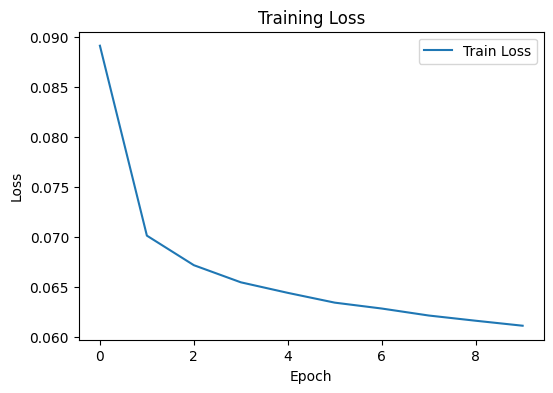

In [60]:
import torch.nn as nn
import torch.optim as optim

# Define model
class TranscriptionModel(nn.Module):
    def __init__(self, input_size=4096, hidden_size1=512, hidden_size2=256, output_size=128):
        super(TranscriptionModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu2(self.layer2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.output(x))
        return x

# Initialize model, loss, and optimizer
model = TranscriptionModel()
criterion = nn.BCELoss()  # Binary cross-entropy for multi-label
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # trying to use the GPU is available
        optimizer.zero_grad() # not using some features that are not needed for training
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")


# Plot training history
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), "transcription_model.pt")

import pickle
with open("train_losses.pkl", "wb") as f:
    pickle.dump(train_losses, f)

## Evaluation


In multi-label classification tasks like music transcription, where the model predicts which notes are active in an audio frame, accuracy alone is often insufficient. This is because most notes are inactive in any given frame, so a naive model could predict all zeros and still get high accuracy.

To better understand model performance, we use the following metrics:

| Metric    | Description                                                                                           | Relevance in Music Transcription                          |
|-----------|---------------------------------------------------------------------------------------------------|----------------------------------------------------------|
| Precision | The ratio of correctly predicted active notes to all notes predicted as active.                   | Measures how many predicted notes are actually correct.  |
| Recall    | The ratio of correctly predicted active notes to all true active notes.                           | Measures how well the model finds all active notes.       |
| F1-Score  | The harmonic mean of Precision and Recall, balancing both metrics.                               | Useful when we want a balance between detecting notes and avoiding false alarms. |
| Accuracy  | The ratio of correct predictions (both active and inactive) to all predictions.                   | Can be misleading in imbalanced data like note activity. |

**Why these matter for us:**  
In music transcription, missing an active note (low recall) means the model fails to detect a real sound. Predicting too many notes that aren't actually played (low precision) means the transcription contains false notes. The F1-score helps balance these two.


In [63]:
model.eval()
with torch.no_grad():
    Xtest_tensor = Xtest_tensor.to(device)
    Ypred = (model(Xtest_tensor) > 0.5).cpu().numpy()

f1 = f1_score(Ytest, Ypred, average='micro')
print("Test F1-score:", f1)


Test F1-score: 0.35689959798222926


In [96]:

for i in range(0,20):
    mask = (model(Xtest_tensor)[i] > 0.5)
    indices = torch.nonzero(mask).squeeze().cpu().numpy()

    true_positive_indices = np.where(Ytest[i] == 1)[0]
    print(f"guess: {indices}, real: {true_positive_indices}")


guess: [], real: [62 74]
guess: 58, real: [46 58 67]
guess: 70, real: [62 70]
guess: 57, real: [45 57 66]
guess: [], real: [62 69]
guess: 55, real: [43 55 70]
guess: [62 70], real: [62 70]
guess: 57, real: [45 57 69]
guess: [57 65], real: [62 65]
guess: [], real: [38 50 74]
guess: 62, real: [38 50]
guess: [65 74], real: [62 65 69 74]
guess: [], real: [61 64 69 76]
guess: 81, real: [61 64 69 81]
guess: [65 77], real: [62 65 69 77]
guess: [62 65], real: [62 65 69 81]
guess: [], real: []
guess: [62 81], real: [60 62 66 81]
guess: [55 58], real: []
guess: 70, real: [67 70 82]


In [85]:
# Assuming Ytest is a NumPy array or a tensor
true_positive_indices = np.where(Ytest[6] == 1)[0]  # If Ytest is NumPy

# If Ytest is a PyTorch tensor, use:
# true_positive_indices = torch.nonzero(Ytest[1]).squeeze().cpu().numpy()

print(true_positive_indices)


[62 70]


Comparing first 10 predicted vs true positive indices:
Predicted index: 62 	 True index: 62
Predicted index: 70 	 True index: 70


### Interpretation

It is extremely important now to interpret the result we got. Firstly, we need to keep in mind the fact that we are working with multiclass data. For very sparse multi-label, F1 around 0.3-0.4 is often expected unless you tune and train a lot more. 

To understand that we need to keep in mind that random guessing performs terribly. If the model predicts every label with 0.5 probability, it will often guess 50–60 positives per sample.

- But only 2 of those are actually correct.

- Precision and recall crash → F1 near 0.01–0.05

Also if we look at empirical evidence (from papers and practice) in multi-label music tagging, audio tagging, or multi-label NLP, where positives are rare:

- **Baseline F1 often sits around 0.3 to 0.4**

- **Good models with heavy tuning reach 0.5–0.6**

- **It’s very rare to go over 0.7 unless you have well-balanced data**

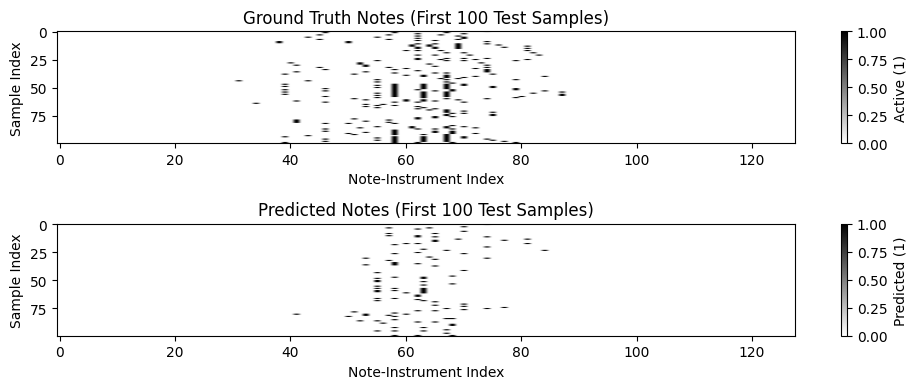

In [26]:
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.imshow(Ytest[:100], aspect='auto', cmap='binary')
plt.title("Ground Truth Notes (First 100 Test Samples)")
plt.xlabel("Note-Instrument Index")
plt.ylabel("Sample Index")
plt.colorbar(label="Active (1)")
plt.subplot(2, 1, 2)
plt.imshow(Ypred[:100], aspect='auto', cmap='binary')
plt.title("Predicted Notes (First 100 Test Samples)")
plt.xlabel("Note-Instrument Index")
plt.ylabel("Sample Index")
plt.colorbar(label="Predicted (1)")
plt.tight_layout()
plt.show()

## Trying a CNN model

In this section I am going to do some modification such as susing a CNN and also uploading the data in the form of spectograms so

In [39]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import librosa


def waveform_to_mel_spectrogram(waveforms, sr=44100, n_mels=64, n_fft=2048, hop_length=1024):
    specs = []
    for waveform in tqdm(waveforms, desc="Converting waveforms to mel spectrograms"):
        mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel_spec, ref=np.max)
        specs.append(mel_db)
    return np.array(specs)

# Example: Convert your datasets
Xtrain_spec = waveform_to_mel_spectrogram(Xtrain)
Xvalid_spec = waveform_to_mel_spectrogram(Xvalid)
Xtest_spec = waveform_to_mel_spectrogram(Xtest)

print("Spectrogram shapes:", Xtrain_spec.shape, Xvalid_spec.shape, Xtest_spec.shape)


Converting waveforms to mel spectrograms: 100%|█████████████████████████████████| 10000/10000 [00:23<00:00, 420.27it/s]

Spectrogram shapes: (62500, 64, 5) (10000, 64, 5) (10000, 64, 5)


In [49]:
class SpectrogramDataset(Dataset):
    def __init__(self, specs, labels):
        # specs shape: (N, n_mels, time_frames)
        self.specs = torch.tensor(specs, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.specs)

    def __getitem__(self, idx):
        # Add channel dimension: CNN expects (C, H, W)
        x = self.specs[idx].unsqueeze(0)
        y = self.labels[idx]
        return x, y

train_dataset = SpectrogramDataset(Xtrain_spec, Ytrain)
valid_dataset = SpectrogramDataset(Xvalid_spec, Yvalid)
test_dataset = SpectrogramDataset(Xtest_spec, Ytest)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)


One of the important things that we ought to look at here is the fact.

In [50]:
class SimpleCNN(nn.Module):
    def __init__(self, n_mels, time_frames, output_size=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        # Calculate flattened size after two poolings
        h = n_mels // 4
        w = time_frames // 4
        self.fc1 = nn.Linear(32 * h * w, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

n_mels, time_frames = Xtrain_spec.shape[1], Xtrain_spec.shape[2]
model = SimpleCNN(n_mels, time_frames).to('cuda' if torch.cuda.is_available() else 'cpu')


In [54]:

device = next(model.parameters()).device
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
valid_losses = []

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

for epoch in range(10):
    train_loss = train_epoch(model, train_loader)
    valid_loss = eval_epoch(model, valid_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

# Plotting loss curves
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

save_path = os.path.expanduser("~/Documents/loss_curve.png") # Saving the photo
plt.savefig(save_path)

plt.show()

# Calculate F1 on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in valid_loader:
        x = x.to(device)
        out = model(x)
        preds = torch.sigmoid(out).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(y.numpy())

import numpy as np
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Assuming binary classification, threshold at 0.5
pred_labels = (all_preds >= 0.5).astype(int)

accuracy = accuracy_score(all_labels.flatten(), pred_labels.flatten())
precision = precision_score(all_labels, pred_labels, average='macro', zero_division=0)
recall = recall_score(all_labels, pred_labels, average='macro', zero_division=0)
f1 = f1_score(all_labels, pred_labels, average='macro', zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


KeyboardInterrupt



## To dos
- add some analysis on the frequencies i got and compare the two training i got.
- 

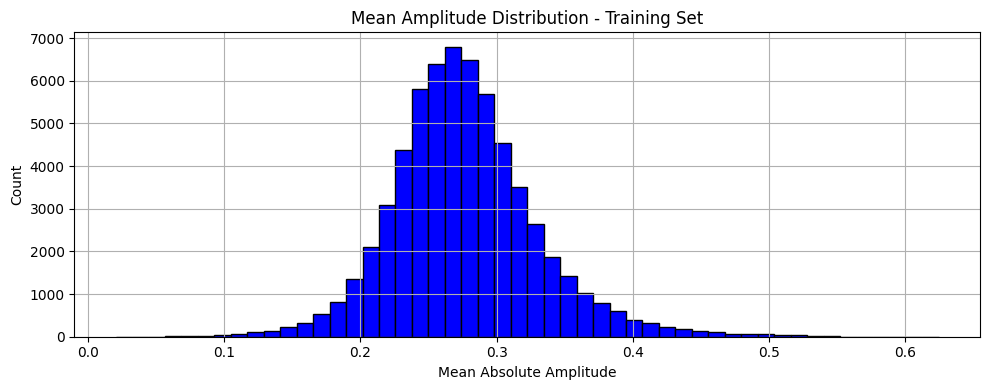

Mean of mean amplitudes: 0.27614978
Mean of std amplitudes: 0.3401256
Mean of peak-to-peak: 1.8715175


## Resources
- https://www.electrical4u.com/rms-or-root-mean-square-value-of-ac-signal/
- https://en.wikipedia.org/wiki/Spectrogram
- https://www.geeksforgeeks.org/deep-learning/multi-layer-perceptron-learning-in-tensorflow/

Text(0.5, 1.0, 'Distribution of Mean Amplitudes')

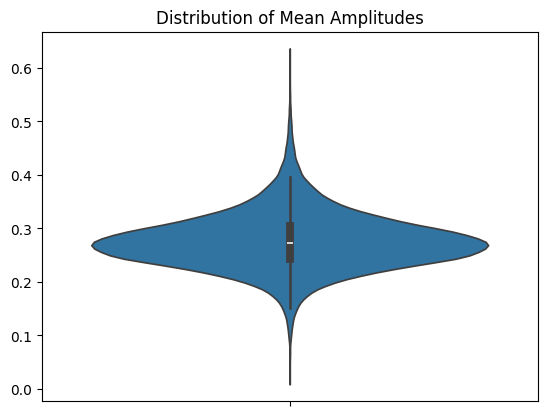